# 機械学習をPythonで実践する-9　　～ 決定木 ～

In [148]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import polars as pl
import seaborn as sns
from itertools import product
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, label_binarize
# import statsmodels.api as sma
from sklearn.model_selection import train_test_split ,LeaveOneOut, cross_val_score, KFold, RepeatedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, log_loss, confusion_matrix,ConfusionMatrixDisplay, \
accuracy_score, precision_score, recall_score,precision_recall_curve,f1_score,roc_curve,auc
from scipy.stats import hmean
from sklearn.decomposition import PCA
import plotly.express as px
# from sklearn.pipeline import Pipeline
# from sklearn.neighbors import KNeighborsRegressor
from sklearn.datasets import fetch_openml
import time
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage,dendrogram,fcluster
from sklearn import tree

%matplotlib inline
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## ○ 決定木
* 決定木(回帰)
    * sklearn.tree.DecisionTreeRegressor
        * max_depth: 木の深さを指定
        * min_samples_split: 最低限分割に必要なデータ数（分割対象の領域内データ数）を指定。
        * ccp_alpha: cost complexity pruningのalphaの値を指定
    * 使い方は他のsklearnのモデルと同じ
    * パラメータを指定しないと最後まで分割し過学習するので注意
* 決定木(分類)
    * sklearn.tree.DecisionTreeClassifier
    * 使い方はDecisionTreeClassifierと同じ

In [8]:
# tipsデータセットをインポート
df = sns.load_dataset('tips')
# ダミー変数を作成
df = pd.get_dummies(df, drop_first=True)

# 目的変数はtipとする
y_col = 'tip'
X = df.drop(columns=[y_col])
y = df[y_col]

# hold-out
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

決定木のアルゴリズム上、質的変数もそのまま分岐の判断に使えるので理論的にはダミー変数は不要だが、  
scikit-learnの仕様上はダミー変数化しておく必要がある。  
また、決定木の分岐の際は学習データとテストデータで同じ特徴量同士の値の比較を行って分岐しているので、  
標準化を行う必要はない。

In [9]:
# 決定木で学習
model = tree.DecisionTreeRegressor(max_depth=4)
model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4)

In [12]:
# 予測
y_pred = model.predict(X_test)
y_pred

array([2.65967742, 3.48      , 2.65967742, 3.075     , 4.1       ,
       3.075     , 3.48      , 3.36428571, 3.48      , 4.73823529,
       2.66625   , 2.66625   , 2.470625  , 1.8085    , 2.470625  ,
       3.78791667, 1.8085    , 2.470625  , 2.65967742, 3.78791667,
       3.78791667, 2.66625   , 1.91857143, 2.470625  , 2.470625  ,
       4.1       , 1.8085    , 3.78791667, 3.78791667, 1.91857143,
       2.470625  , 1.8085    , 1.91857143, 1.8085    , 2.65967742,
       2.470625  , 2.65967742, 1.8085    , 6.73      , 1.91857143,
       1.8085    , 1.8085    , 1.91857143, 3.78791667, 1.8085    ,
       2.65967742, 2.65967742, 3.36428571, 2.65967742, 3.78791667,
       3.36428571, 3.48      , 3.48      , 6.73      , 1.8085    ,
       1.8085    , 3.78791667, 3.78791667, 2.470625  , 1.8085    ,
       3.36428571, 1.91857143, 3.36428571, 3.78791667, 3.78791667,
       1.91857143, 4.1       , 2.66625   , 1.8085    , 3.36428571,
       1.91857143, 1.8085    , 3.78791667, 2.470625  ])

In [17]:
y_test[:5]

64     2.64
63     3.76
55     3.51
111    1.00
225    2.50
Name: tip, dtype: float64

結構外してそう

In [18]:
# MSEで精度を評価
mean_squared_error(y_test,y_pred)

1.1060246260428703

In [21]:
# R-squared（決定係数）を算出
model.score(X_test, y_test)

0.3590618660303134

1.0からかなり離れているので、残差が大きく、精度が良いとは言えない。

## ○ 決定木の可視化
* 決定木の可視化(描画)
    * sklearn.tree.plot_tree
        * decision_tree: モデルインスタンス
        * fontsize: フォントのサイズを指定
        * feature_name: 特徴量の名前をリストで渡す(model.feature_names_in_が便利)
    * sklearnのtreeモデルを引数にする
    * 図の内容が戻り値で返ってくる
<br></br>
* 決定木の可視化(テキスト)
    * sklearn.tree.export_text
    * 使い方はplot_treeと同じ。plot_treeよりもよく使われるかも。
    * print()関数に渡して表示することで綺麗に表示される

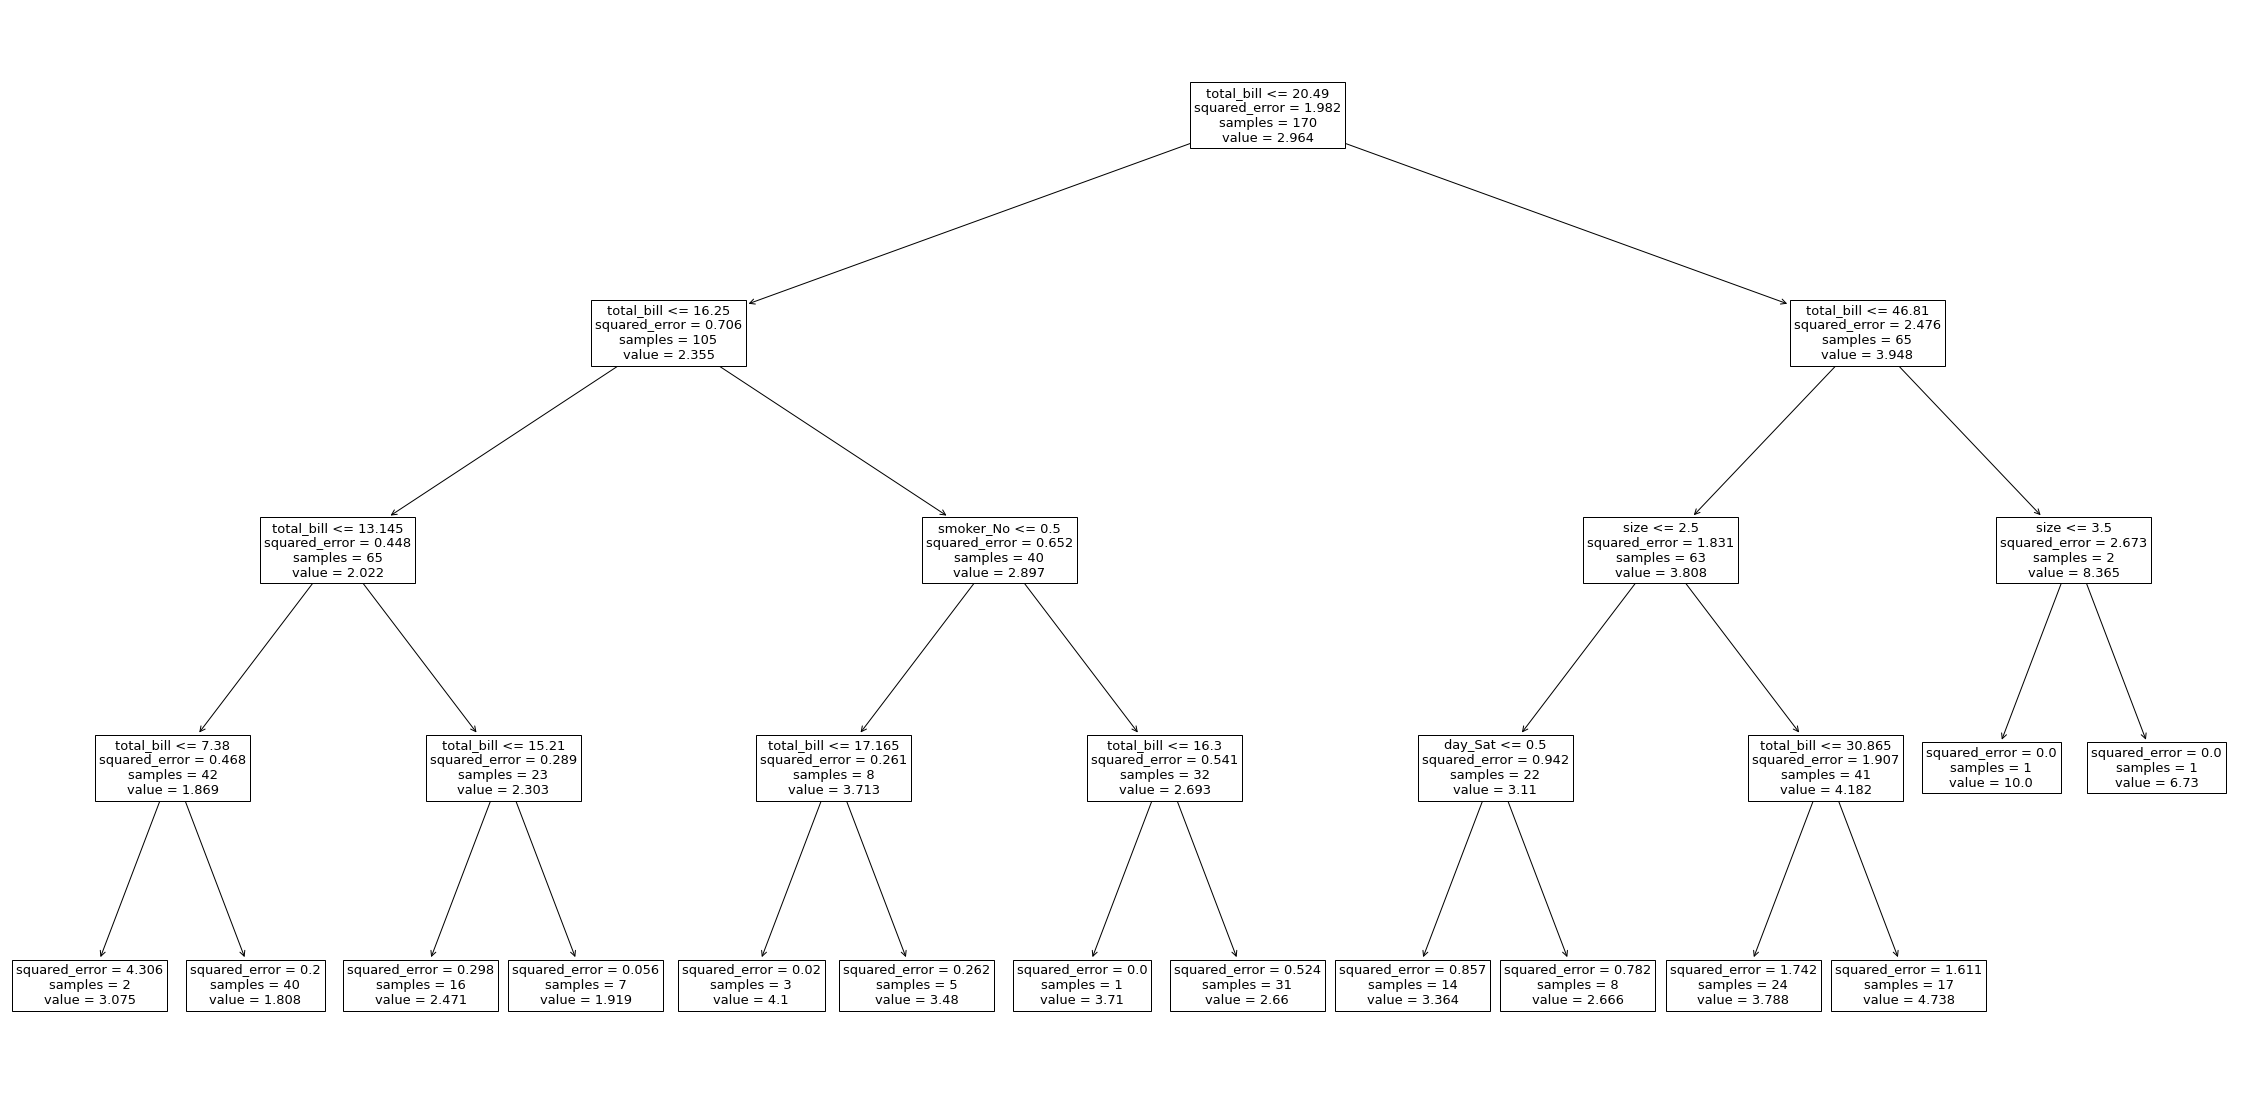

In [26]:
# 描画サイズを指定
plt.figure(figsize=(40, 20))
# model.feature_names_inで特徴量名のリストを取得可能。JupyterLabでそのまま表示すると余分な情報が含まれるので、戻り値を捨てる。
_ = tree.plot_tree(model, fontsize=13, feature_names=model.feature_names_in_)

ノードは4項目あり、上から分岐条件、損失(残差)、領域のデータ数(samples)、目的変数の平均値(value)を表す。  
（葉の場合は分岐条件を除く）  
あるノード（節）でのsquared_error（損失）は、その下にあるノードまたは葉の損失の合計よりも大きいことが分かる。  
これが繰り返されて損失合計が小さくなるように葉が決定されている。  

決定木は目的変数に大きく寄与する特徴量ほど決定木の上部で分岐される。  
このケースではtotal_billやsizeが目的変数に大きく寄与していることがわかる。  
条件が質的変数のときは0,1ではなく中間の0.5より大きいか否かで分岐を表現する。　　


In [28]:
# もう一方の書き方。feature_namesにはリスト化して入れる必要あり。
print(tree.export_text(model, feature_names=list(model.feature_names_in_)))

|--- total_bill <= 20.49
|   |--- total_bill <= 16.25
|   |   |--- total_bill <= 13.14
|   |   |   |--- total_bill <= 7.38
|   |   |   |   |--- value: [3.08]
|   |   |   |--- total_bill >  7.38
|   |   |   |   |--- value: [1.81]
|   |   |--- total_bill >  13.14
|   |   |   |--- total_bill <= 15.21
|   |   |   |   |--- value: [2.47]
|   |   |   |--- total_bill >  15.21
|   |   |   |   |--- value: [1.92]
|   |--- total_bill >  16.25
|   |   |--- smoker_No <= 0.50
|   |   |   |--- total_bill <= 17.16
|   |   |   |   |--- value: [4.10]
|   |   |   |--- total_bill >  17.16
|   |   |   |   |--- value: [3.48]
|   |   |--- smoker_No >  0.50
|   |   |   |--- total_bill <= 16.30
|   |   |   |   |--- value: [3.71]
|   |   |   |--- total_bill >  16.30
|   |   |   |   |--- value: [2.66]
|--- total_bill >  20.49
|   |--- total_bill <= 46.81
|   |   |--- size <= 2.50
|   |   |   |--- day_Sat <= 0.50
|   |   |   |   |--- value: [3.36]
|   |   |   |--- day_Sat >  0.50
|   |   |   |   |--- value: [2.67]

こちらの方がシンプルで見やすいかも。

In [38]:
# 検算
print(f"データ数：{len(X_train[X_train['total_bill'] >= 20.49])}")
print(f"目的変数の平均：{y_train.loc[X_train[X_train['total_bill'] >= 20.49].index].mean()}")

データ数：65
目的変数の平均：3.948


確かにデータ数と目的変数の平均は決定木と同じになる。

## ○ 決定木の特徴量の重要度を描画
.feature_importances_属性で特徴量の重要度をリストで取得できる

In [39]:
# 特徴量の重要度を取得
model.feature_importances_

array([0.85278323, 0.10370839, 0.        , 0.03169922, 0.        ,
       0.01180916, 0.        , 0.        ])

In [51]:
model.feature_names_in_

array(['total_bill', 'size', 'sex_Female', 'smoker_No', 'day_Fri',
       'day_Sat', 'day_Sun', 'time_Dinner'], dtype=object)

Text(0, 0.5, 'features')

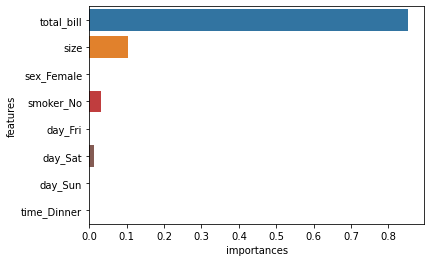

In [54]:
# 重要度を描画
sns.barplot(x=model.feature_importances_, y=model.feature_names_in_)
plt.xlabel('importances')
plt.ylabel('features')

重要度は0～1.0の値をとる。total_billは8割以上の重要度になっている。  
このように決定木からどの特徴量が重要そうか確認できる。  
重要度の具体的な計算方法については講義を参考。

## ○ Minimal Cost Complexity Pruning（決定木の剪定）
.cost_complexity_pruning_path(X, y)で、$\alpha$と不純度をリストで取得する。X,yは学習データ。  
$\alpha$は葉の数に対する損失のペナルティ項（の係数）である。  
ここでの不純度は回帰であればRSS、分類であればジニ不純度。  
それぞれの$\alpha$でのモデルの精度を計測し，最良の$\alpha$を使用する。  


In [55]:
# 決定木のインスタンス生成。剪定するため、max_depthは指定せず最後まで学習させる。
model = tree.DecisionTreeRegressor(random_state=0)
path = model.cost_complexity_pruning_path(X_train, y_train)

In [62]:
# 不純度はいらないので、pathのうちccp_alphasだけ取得。ccpはCost Complexity Pruningの略。
eff_alphas = path.ccp_alphas

In [73]:
eff_alphas[:5]

array([0.00000000e+00, 1.04491579e-17, 1.56737368e-17, 4.41176471e-07,
       1.17647059e-06])

各枝におけるalphaが計算される。CCPでは最も小さいalphaを持つ枝から剪定していくので、  
まず1.04e-17の枝から切り落とされ、次は1.56e-17の枝・・・というようにalphaが増えるにつれて  
切り落とされる枝が増えていく。切り落とすalphaの上限はtree.DecisionTreeXXXXでインスタンス生成時に指定する。


In [63]:
# 各alphaについてモデルを作成、学習
models = []
for eff_alpha in eff_alphas:
    # ccp_alphaを指定することで、alphaに応じて剪定が行われる。
    model = tree.DecisionTreeRegressor(random_state=0, ccp_alpha=eff_alpha)
    model.fit(X_train, y_train)
    models.append(model)

In [66]:
# 学習データとテストデータに対するMSEを算出。
# 学習データに対するMSEを算出するのは過学習気味かどうか確認するため。
train_scores = [mean_squared_error(y_train, model.predict(X_train)) for model in models]
test_scores = [mean_squared_error(y_test, model.predict(X_test)) for model in models]

Text(0, 0.5, 'MSE')

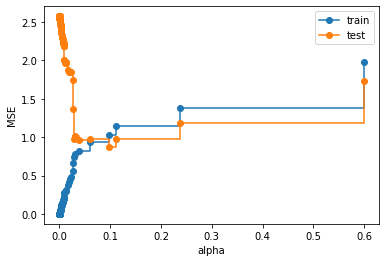

In [71]:
# MSEとalphaの推移を描画
plt.plot(eff_alphas, train_scores, marker='o', label='train', drawstyle='steps-post')
plt.plot(eff_alphas, test_scores, marker='o', label='test', drawstyle='steps-post')
plt.legend()
plt.xlabel('alpha')
plt.ylabel('MSE')

alphaが0に近いときは学習データに対するMSEが小さいが、テストデータに対するMSEが大きいので、  
過学習気味になっていることが分かる。alphaが0に近いということは剪定をほぼしないということなので、  
varianceが高くなり過ぎてしまい汎化性能が落ちているということである。  
alphaが0から大きくなり、0.1程度になるとテストデータに対するMSEは最も小さくなっているため、ここで汎化性能が最大になることがわかる。  
0.1からさらに大きくなると、徐々に学習データ、テストデータともにMSEが大きくなっていく。  
これは、alphaが大きくなって剪定が進むことでモデルが単純化されbiasが大きくなるためである。  
このようにbias-varianceトレードオフは適切なモデルを採用する上で非常に重要な概念である。  

モデル策定の際どのalphaを指定すべき検討するときは上記のような図を描くとよい。

In [75]:
# 最もbiasが高いモデルを見てみる。
print(tree.export_text(models[-1], feature_names=list(models[-1].feature_names_in_)))

|--- value: [2.96]



単純化されすぎて2.96という予測値しか返さないモデルになっている。

## ○ 決定木（分類）
参考：https://datawokagaku.com/decision_tree_classifier/
* sklearn.tree.DecisionTreeClassifier
    * max_depth: 木の深さを指定
    * min_samples_split: 最低限分割に必要なデータ数（分割対象の領域内データ数）を指定。
    * ccp_alpha: cost complexity pruningのalphaの値を指定
* 使い方はRegressorと同じ  

In [2]:
# seabornのtitanicデータセットをインポート
df = sns.load_dataset('titanic')

In [56]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
6,0,1,male,54.0,0,0,51.8625,S,First,man,True,E,Southampton,no,True
10,1,3,female,4.0,1,1,16.7000,S,Third,child,False,G,Southampton,yes,False
11,1,1,female,58.0,0,0,26.5500,S,First,woman,False,C,Southampton,yes,True


In [20]:
# NaNを落とす。
df = df.dropna()

# survivedとalive以外を特徴量にする。df.drop(columns=['survived', 'alive']) →こっちの方がすっきりするかも。
X = df.loc[:, (df.columns != 'survived') &  (df.columns != 'alive')]
X = pd.get_dummies(X, drop_first=True)
y = df['survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [31]:
# 剪定するので、max_depthは指定せず最後まで学習
model = tree.DecisionTreeClassifier(random_state=0)

In [32]:
# effective alphaと不純度を取得。辞書で返ってくる
path = model.cost_complexity_pruning_path(X_train, y_train)
path

{'ccp_alphas': array([0.        , 0.00656168, 0.00656168, 0.00699913, 0.00726832,
        0.0077282 , 0.00787402, 0.01049869, 0.0111986 , 0.0118874 ,
        0.01526093, 0.01880243, 0.02677358, 0.12717222]),
 'impurities': array([0.        , 0.01312336, 0.02624672, 0.04024497, 0.05478161,
        0.07023802, 0.07811203, 0.09910941, 0.11030801, 0.14597022,
        0.2375358 , 0.2939431 , 0.32071667, 0.4478889 ])}

In [33]:
# それぞれ変数に格納。
eff_alphas, impurities = path.ccp_alphas, path.impurities

In [34]:
# effective alphaごとにモデル出力。（eff_alphasごとに剪定する）
models = []
for alpha in eff_alphas:
    model = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=alpha)
    model.fit(X_train, y_train)
    models.append(model)

In [ ]:
models

[DecisionTreeClassifier(random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.006561679790026247, random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.006561679790026247, random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.006999125109361329, random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.007268322228952147, random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.00772820064158646, random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.007874015748031496, random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.010498687664041995, random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.011198600174978122, random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.01188740296351846, random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.015260930221560144, random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.01880243307726162, random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.02677357637987557, random_state=0),
 DecisionTreeClassifier(ccp_alpha=0.1271722235752164, random_state=0)]

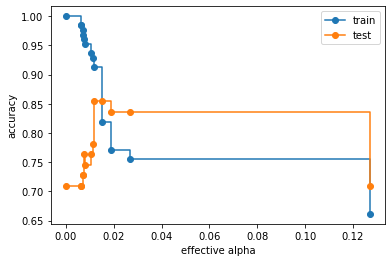

In [44]:
# .scoreで精度（accuracy）を算出
train_scores = [model.score(X_train, y_train) for model in models]
test_scores = [model.score(X_test, y_test) for model in models]

# 描画
fig, ax = plt.subplots()
ax.set_xlabel('effective alpha')
ax.set_ylabel('accuracy')
ax.plot(eff_alphas, train_scores, marker='o', drawstyle='steps-post', label='train')
ax.plot(eff_alphas, test_scores, marker='o', drawstyle='steps-post', label='test')
ax.legend()

alpha=0.011~0.015あたりが精度良さそう。

In [57]:
models[10]

DecisionTreeClassifier(ccp_alpha=0.015260930221560144, random_state=0)

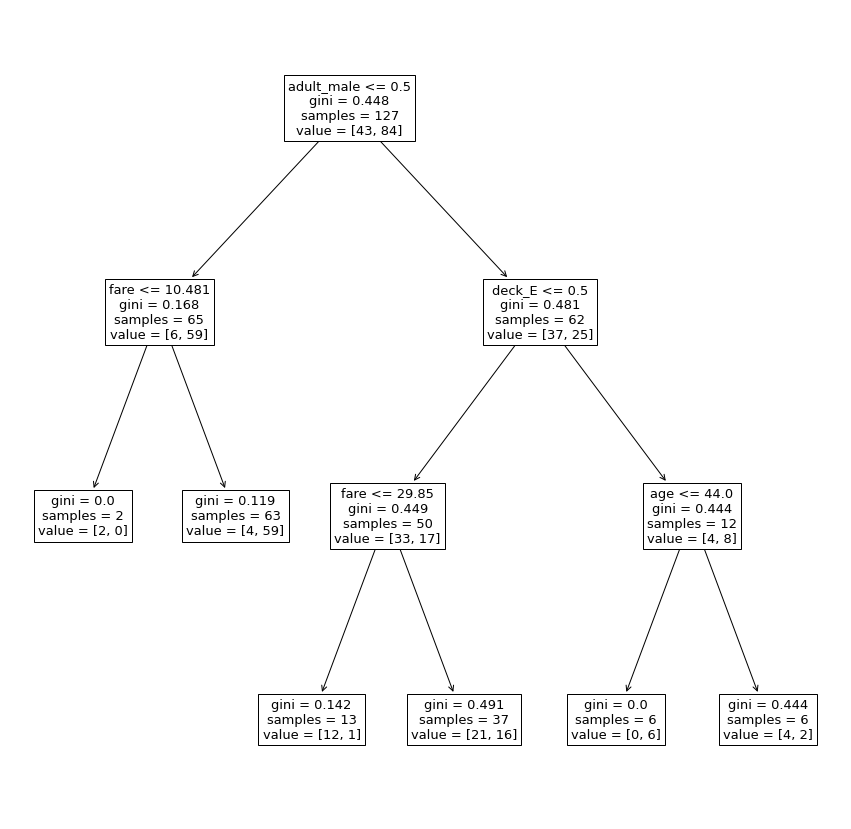

In [68]:
# 精度良さそうなモデルの決定木を可視化してみる
plt.figure(figsize=(15,15))
_ = tree.plot_tree(models[10], fontsize=13, feature_names=model.feature_names_in_)

In [70]:
models[10].classes_

array([0, 1])

value = [a, b]はsurvivedのクラスごとの数を表している。  
model.classes_より、左が死亡、右が生存の数。

In [118]:
accuracy_score(y_test, models[10].predict(X_test))

0.8545454545454545

In [114]:
# 検算
idx = X_train.loc[(X_train['adult_male'] == False),:].index
print(f'成人男性でない数：{len(idx)}')
print(f'そのうちの死者数:{y_train[idx].value_counts()[0]}')
print(f'そのうちの生存者数:{y_train[idx].value_counts()[1]}')


成人男性でない数：65
そのうちの死者数:6
そのうちの生存者数:59


確かに上記ツリーと同じ内訳になっている。  
成人男性でない、かつfareが10.481よりも大きいと生存する確率が高いといえそう。

In [69]:
models[10].predict(X_test)

array([0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1])

In [116]:
X_test.head()

,pclass,age,sibsp,parch,fare,adult_male,alone,sex_male,embarked_Q,embarked_S,...,who_man,who_woman,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,embark_town_Queenstown,embark_town_Southampton
484,1,25.0,1,0,91.0792,True,False,1,0,0,...,1,0,1,0,0,0,0,0,0,0
110,1,47.0,0,0,52.0000,True,True,1,0,1,...,1,0,0,1,0,0,0,0,0,1
195,1,58.0,0,0,146.5208,False,True,0,0,0,...,0,1,1,0,0,0,0,0,0,0
496,1,54.0,1,0,78.2667,False,False,0,0,0,...,0,1,0,0,1,0,0,0,0,0
889,1,26.0,0,0,30.0000,True,True,1,0,0,...,1,0,0,1,0,0,0,0,0,0


## ○ 入力されたデータが決定木のどの葉にたどり着いたのか調べる方法
決定木の出力結果を詳しく見たいときなどに使える。  

In [224]:
# tipsデータセットをインポート
df = pl.from_pandas(sns.load_dataset('mpg'))

# 今回は単純に欠損値を落とす。
df = df.drop_nulls()

# 学習データ、目的変数を定義
X = df.drop(['mpg'])
y = df.get_column('mpg')

# カテゴリ変数のカラム名をリスト化
category_cols = X.select(pl.col(pl.Utf8)).columns

# ラベルエンコーディング（LabelEncoderではなく、OrdinalEncoderを使う）
oe = OrdinalEncoder()
# pandasで返ってくるように指定。polarsは指定できない模様
oe.set_output(transform='pandas')
# カテゴリ変数をエンコーディング。polars.DFはそのまま入れられないのでpandasに変換する。
X = X.with_columns( pl.from_pandas(oe.fit_transform(X.select(category_cols).to_pandas())) )

# hold-out
X_train, X_test, y_train, y_test = train_test_split(X.to_pandas(), y.to_pandas(), test_size=0.3, random_state=0)


In [225]:
model = tree.DecisionTreeRegressor(max_depth=2, random_state=0).fit(X_train, y_train)

model.applyによって、テストデータがどの葉(ID)にたどり着くのかが分かる。  
下の例では最初のデータは決定木の一番左の葉（一番目の葉）にたどり着くことを表している。  
また、np.count_nonzeroで葉にたどり着くテストデータの総数をカウントできる。

In [226]:
model.apply(X_test)

array([2, 3, 6, 3, 3, 5, 3, 3, 5, 2, 2, 6, 2, 6, 6, 3, 2, 6, 2, 3, 5, 5,
       2, 5, 3, 6, 3, 2, 5, 6, 5, 3, 2, 2, 5, 3, 2, 6, 6, 6, 6, 3, 3, 6,
       2, 6, 3, 6, 6, 5, 2, 6, 6, 2, 3, 5, 5, 5, 2, 2, 5, 2, 2, 6, 2, 5,
       6, 3, 2, 3, 2, 2, 5, 6, 5, 6, 2, 6, 2, 2, 5, 3, 5, 2, 6, 5, 2, 3,
       3, 2, 2, 6, 2, 5, 5, 2, 3, 2, 2, 2, 6, 2, 2, 2, 3, 5, 2, 5, 3, 6,
       6, 2, 2, 5, 3, 2, 3, 5])

In [227]:
np.count_nonzero(model.apply(X_test) == 5)

25

model.tree_.valueで決定木の各ノードおよび葉の値を取得できる。  

In [228]:
model.tree_.value

array([[[23.1689781 ]],

       [[29.12428571]],

       [[26.36125   ]],

       [[32.80833333]],

       [[16.94701493]],

       [[19.03636364]],

       [[14.1245614 ]]])

決定木を可視化するとわかるように一番左の枝のノード→その下の葉という順に出力されている。  
そして.applyのIDもこの順に対応している。

[Text(0.5, 0.8333333333333334, 'x[0] <= 5.5\nsquared_error = 60.184\nsamples = 274\nvalue = 23.169'),
 Text(0.25, 0.5, 'x[5] <= 78.5\nsquared_error = 32.348\nsamples = 140\nvalue = 29.124'),
 Text(0.125, 0.16666666666666666, 'squared_error = 20.625\nsamples = 80\nvalue = 26.361'),
 Text(0.375, 0.16666666666666666, 'squared_error = 24.227\nsamples = 60\nvalue = 32.808'),
 Text(0.75, 0.5, 'x[2] <= 139.5\nsquared_error = 13.5\nsamples = 134\nvalue = 16.947'),
 Text(0.625, 0.16666666666666666, 'squared_error = 10.081\nsamples = 77\nvalue = 19.036'),
 Text(0.875, 0.16666666666666666, 'squared_error = 4.254\nsamples = 57\nvalue = 14.125')]

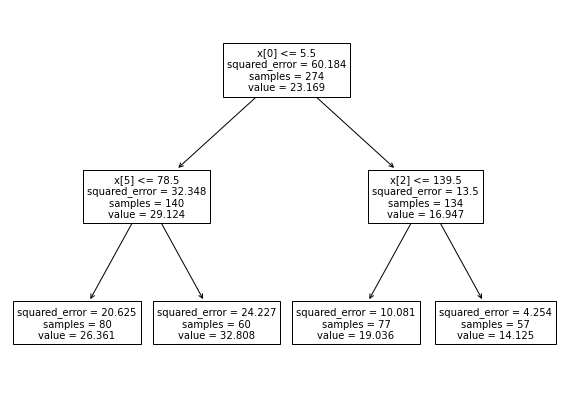

In [183]:
plt.figure(figsize=(10,7))
tree.plot_tree(model, fontsize=10)

In [229]:
model.apply(X_test)[:10]

array([2, 3, 6, 3, 3, 5, 3, 3, 5, 2])

In [230]:
model.predict(X_test)[:10]

array([26.36125   , 32.80833333, 14.1245614 , 32.80833333, 32.80833333,
       19.03636364, 32.80833333, 32.80833333, 19.03636364, 26.36125   ])

下記のようにmodel.tree_.valueに値を代入することで葉の値を変更することも可能。  
（GBDTを実装するときなどに使う）

In [200]:
model.tree_.value[2, 0, 0] = 3

In [202]:
model.tree_.value[2, 0, 0]

3.0

[Text(0.5, 0.8333333333333334, 'x[0] <= 5.5\nsquared_error = 60.184\nsamples = 274\nvalue = 23.169'),
 Text(0.25, 0.5, 'x[5] <= 78.5\nsquared_error = 32.348\nsamples = 140\nvalue = 29.124'),
 Text(0.125, 0.16666666666666666, 'squared_error = 20.625\nsamples = 80\nvalue = 3.0'),
 Text(0.375, 0.16666666666666666, 'squared_error = 24.227\nsamples = 60\nvalue = 32.808'),
 Text(0.75, 0.5, 'x[2] <= 139.5\nsquared_error = 13.5\nsamples = 134\nvalue = 16.947'),
 Text(0.625, 0.16666666666666666, 'squared_error = 10.081\nsamples = 77\nvalue = 19.036'),
 Text(0.875, 0.16666666666666666, 'squared_error = 4.254\nsamples = 57\nvalue = 14.125')]

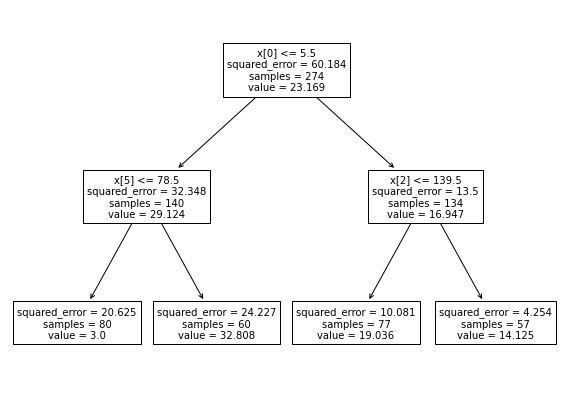

In [203]:
plt.figure(figsize=(10,7))
tree.plot_tree(model, fontsize=10)

In [234]:
p = model.predict(X_train)
r = y_train - p

In [243]:
%%time
df_test = pl.DataFrame({'p':p, 'leef':model.apply(X_train), 'r': y_train-p, 'p(1-p)': p * (1-p)})
df_test.head()

CPU times: user 3.17 ms, sys: 0 ns, total: 3.17 ms
Wall time: 2.91 ms


p,leef,r,p(1-p)
f64,i64,f64,f64
32.808333,3,-1.808333,-1043.578403
19.036364,5,-2.036364,-343.346777
26.36125,2,-0.36125,-668.554252
32.808333,3,-0.508333,-1043.578403
14.124561,6,-3.124561,-185.378673


In [245]:
df_test.sort('p(1-p)')

p,leef,r,p(1-p)
f64,i64,f64,f64
32.808333,3,-1.808333,-1043.578403
32.808333,3,-0.508333,-1043.578403
32.808333,3,0.691667,-1043.578403
32.808333,3,6.191667,-1043.578403
32.808333,3,-0.608333,-1043.578403
32.808333,3,-6.408333,-1043.578403
32.808333,3,-5.808333,-1043.578403
32.808333,3,-5.408333,-1043.578403
32.808333,3,2.891667,-1043.578403


In [248]:
df_test.get_column('p(1-p)').sum()

-153103.3304958134

In [249]:
%%time
df_test.groupby('leef').agg(pl.col('r').sum()) #/ pl.col('p(1-p)').sum() )

CPU times: user 18.3 ms, sys: 1.2 ms, total: 19.5 ms
Wall time: 5.04 ms


leef,r
i64,f64
2,-4.3698e-13
3,1.9540e-13
5,-1.8119e-13
6,-6.2172e-14
